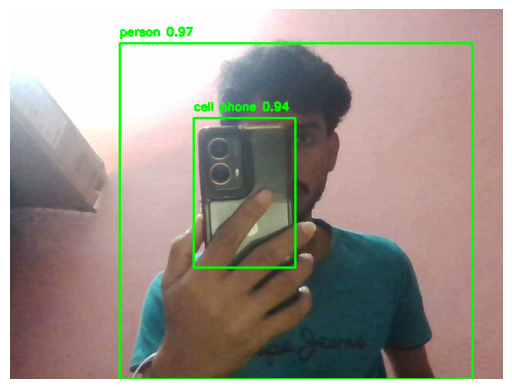

error: OpenCV(4.12.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1367: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvWaitKey'


In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Load YOLOv4 network
net = cv2.dnn.readNet("yolov4.weights", "yolov4.cfg")

# Load the COCO class labels
with open("coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers().flatten()]

# Set up video capture for webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    height, width, channels = frame.shape

    # Prepare the image for YOLOv4
    blob = cv2.dnn.blobFromImage(frame, 1/255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)

    # Get YOLO output
    outputs = net.forward(output_layers)

    boxes, confidences, class_ids = [], [], []

    for output in outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

    if len(indexes) > 0:
        for i in indexes.flatten():
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            confidence = confidences[i]
            color = (0, 255, 0)
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
            cv2.putText(frame, f"{label} {confidence:.2f}", (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)


    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

    # Break condition: press 'q' in notebook input
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
